# Lesson 3

# Random variables to random vectors to random functions

In this lesson we'll progress through random variables to random vectors to random functions.  We'll find at the end that we've fit our first GP!

In [2]:
import arviz as az
import aesara.tensor as at
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import matplotlib.pyplot as plt
import numpy as np

/Users/andre/miniconda3/envs/intuitive_bayes/lib/python3.10/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/docs/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/Users/andre/miniconda3/envs/intuitive_bayes/lib/python3.10/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


# Section 10: Random variables

You've already learned about random variables, so we won't dwell on this step.  Below we draw 10k samples from a normal random variable.

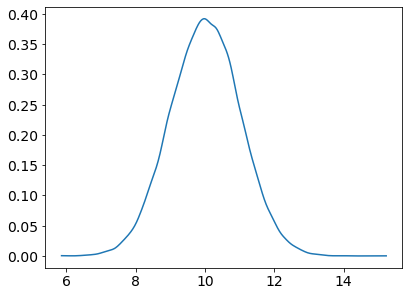

In [3]:
theta = pm.draw(pm.Normal.dist(mu=10, sigma=1), 50_000)

az.plot_dist(theta);

## Now let's generalize to random vectors

In this first example, the distinction between random vector and random variable is just semantic.  A random vector at it's simplest is just random variables stuck together.  

In [4]:
# Make three random variables, put them into a vector
theta1 = pm.Normal.dist(mu=4, sigma=1)
theta2 = pm.Normal.dist(mu=2, sigma=2)
theta3 = pm.Normal.dist(mu=6, sigma=0.5)

# Stick the three random variables together into a random vector
random_vector = [theta1, theta2, theta3]

# Draw samples from the random vector
samples = pm.draw(at.as_tensor_variable(random_vector), draws=10_000)
print("Shape of samples:", samples.shape)

Shape of samples: (10000, 3)


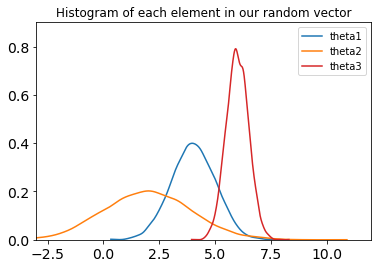

In [5]:
colors = ["C0", "C1", "C3"]

for i in range(3):
    az.plot_dist(samples[:, i], color=colors[i], label="theta" + str(i+1))

plt.title("Histogram of each element in our random vector");
plt.xlim([-3, 12]);
plt.ylim([0.0, 0.9]);

The last example is a trivial case because there is no relationship between the three random variables.  To become a random vector, all we did was stick them together into a list and start thinking about them as something that works together as one "unit".  Usually though, there's not much of a point of talking about random vectors when their random variables have no relationship.  

## Section Recap
* Random variables are mathematical concepts typically denoted $x$
  * A single random draw is one _realized_ number 
* Random variables can be grouped together in random vectors, typically denoted in uppercase as $X$
  * A single random draw generates a vector of realized numbers
  * In our case we got 3
* Random variables can be represented as objects
  * In PyData stack typically scipy and numpy can bve used to instantiate random variables
  * We use Aesara as it provides extra functionality for Bayesian inference


# Sec 20: Multivariate normals

The most important type of random vector for this course is the multivariate normal.  **A multivariate normal distribution is a set of normal random, like the above example, but, they have correlations between each other -- they are not independent**.  In this section, we are going to intuitively describe multivariate normals.  Like kernels, MvNs are a key building block in Gaussian processes.  They're the "Gaussian" part, after all.  

It's important to start by saying that multivariate normals are a generalization of univariate normals.  Meaning, it's equivalent to describe a set of univariate (like the ones above) distributions as a special type of the multivariate case.

What does this look like?  Let's start with the simplest case.  A two dimensional multivariate normal.  We'll start here because it's possible to visualize it in two dimensions.  Lets plot samples for two normal random variables that are independent on a scatterplot.  

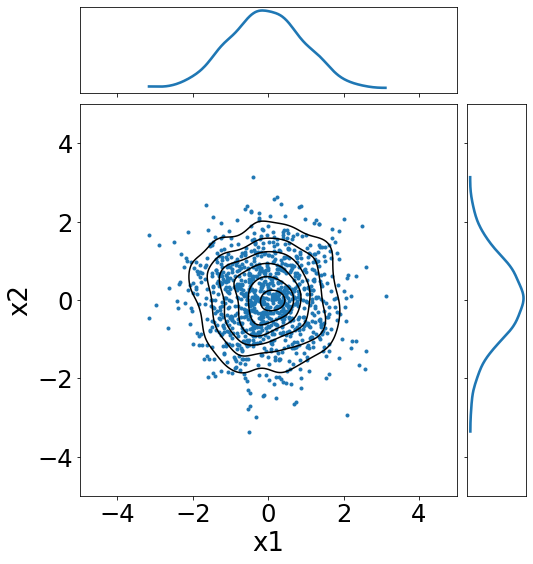

In [6]:
mu = 0.0
sigma = 1.0

x1 = pm.draw(pm.Normal.dist(mu=mu, sigma=sigma), 1000)
x2 = pm.draw(pm.Normal.dist(mu=mu, sigma=sigma), 1000)

axs = az.plot_pair(
    {"x1": x1, "x2": x2},
    kind=["scatter", "kde"],
    marginals=True,
    figsize=(8, 9),
); axs = axs.flatten()

axs[2].set_xlim([-5, 5])
axs[2].set_ylim([-5, 5]);

Notice that I took care to make the figure a square, and to set the axis limits.  Feel free to rerun this code a few times, and draw more samples.  You'll see that the scatter plot lie in a circle.  The more points you draw, the more circular they look.  On the top and on the right there are two other plots verifying that this is in fact two, one dimensional normals.  These are the *marginal* distributions, which we'll come back to in a moment.  Next is the equation for the probability density function for a univariate (meaning one dimenisonal, not two) normal which you've probably seen before:
$$
p(x \mid \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left[ \frac{(x - \mu)^2}{2\sigma^2} \right]
$$
You may not have noticed that factor of $2\pi$ in the denominator.  $\pi$ is of course, all about circles.  $\pi$ of course has everything to do with circles, but we won't get into that here.  You may see that some people describe multivariate normals as "spherical", or as having some amount of "sphericity".  To show why they say this, let's add a dimension and turn our 2d scatterplot into a 3d scatterplot.

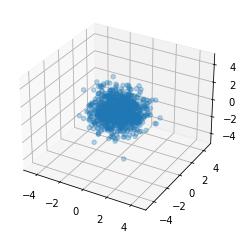

In [7]:
x3 = pm.draw(pm.Normal.dist(mu=mu, sigma=sigma), 1000)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x1, x2, x3, alpha=0.3);

ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5]);
ax.set_zlim([-5, 5]);

### Spheres

Instead of a circle, now it's a sphere!  It's really very difficult to imagine, but try and picture in your mind what this would look like if you added, one more dimension.  You go from a circle in 2d, to a sphere in 3d, to a "sphere" in 4d (you could call it a hypersphere if you want to sound, extra nerdy).  We live in a 3 dimensional world (4 if you count time, which unlike the other three dimensions, seems to only go one way), so I don't want to say it's impossible to picture this round blob in 4 dimensions, because maybe someone out there can, but I can't.  I do think it's important to try though, and to sort of see if you can get a sense of it.

It's an important concept to at least try and wrap your brain around, because spoiler alert: Gaussian processes can live in *infinite* dimensions.  It's helpful to have some sense of what this means when working with them and developing models with them.  Also, and probably more important to know, is that the result of any Bayesian model is the posterior distribution, which is usually quite high dimensional itself.  Many hurdles that you face working with real data, flow down from the fact that high dimensional things are difficult to visualize and tricky to deal with.  Even so, having some intuition here means that you can tackle problems and that may have seemed impossible before!  Thanks for coming to my TED talk.  

### Marginal distributions, Joint distributions, Conditional distributions

**Not sure this belongs here, move this section?**

Since we have work to do and lives to live, let's come back to the mortal plane.  We'll return to the example of with normals in a moment, but first we'll think about discrete random variables to lay some groundwork.  Imagine you work for Toyota in their market research department.  Lately they have been trying to figure out how hard to lean into the EV market.  Define $X$ as a random variable whose values are either, prefer `ICE` (internal combustion engine, or gas) or `EV` (electric vehicle). Then, there is another random variable $Y$, whose values are either `Ad 1`, `Ad 2`, `Ad 3`.  You conduct a focus group of 30 people.  One of the ads is picked at random to be shown to someone.  They watch the ad, then decide whether they'd like a gas or electric vehicle more.  This is repeated for all 30 people.  The table is below:

|           | Y = Ad 1 | Y = Ad 2 | Y = Ad 3 |          |
|-----------|----------|:--------:|:--------:|----------|
| X = ICE   | 04 / 30  |  00 / 30 |  10 / 30 |          |
| X = EV    | 03 / 30  |  10 / 30 |  03 / 30 |          |
|           |          |          |          |          |

The table shows the **joint distribution** of the ad people saw, and the type of car they preferred.  The joint distribution is a useful but maybe a little informal term, referring to the multivariate distribution of two or more variables considered together.  In the example, keep in mind that not every person saw every ad, just one.  Each cell represents how many people out of the 30 both saw a particular ad, and preferred a particular type of car.  So, 10 out of 30 people saw `Ad 2` and preferred `EV`.  Also, 10 out of 30 people saw `Ad 3` and preferred `ICE`.  This is useful information, but what if we want to know:
- How many people saw each ad?
- How many people preferred ICE vs. EV?
Both of these questions are answered by the **marginal distribution**.  The marginal is the distribution for one (or more) of the variables regardless of the values of the other ones.  The bottom row and right side column are not filled in.  Let's fill them in with the marginals.

|          | Y = Ad 1 | Y = Ad 2 | Y = Ad 3 | P(X = x) |
|----------|----------|:--------:|:--------:|----------|
| X = ICE  | 04 / 30  |  00 / 30 |  10 / 30 | 14 / 30  |
| X = EV   | 03 / 30  |  10 / 30 |  03 / 30 | 16 / 30  |
| p(Y = y) | 07 / 30  |  10 / 30 |  13 / 30 |          |

By summing across the rows and columns, we find that people overall regardless of which ad they saw, preferred EVs to ICE cars 16 to 14, or about 53% to 47%.  Not a big difference.  Probably a bit less interesting is that we see that 7 people saw Ad 1, 10 people saw Ad 2, and 13 people saw Ad 3 -- which was just due to random chance, but is roughly even so that makes sense.  

The real insights though, come from some of the **conditionals**.  A conditional distribution depends on the presence of the word "given".  A few interesting cells in this table jump out.  What is the probability someone prefers EVs *given* that they saw Ad 2?  We can calculate this directly from the table.  First we see that 10 out of 30 people saw Ad 2.  Then, we see that all 10 out of those people preferred EVs.  So, if you want people to buy EVs, Ad 2 is looking like it's very persuasive.  A similar story is apparent for gas powered cars and Ad 3.  Overall, 13 people saw Ad 3.  10 of those people preferred ICE cars, while only 3 preferred EVs.   

### The three types of distributions with a bit of math (or, how you'd actually apply this knowledge in practice)

To give you the tools to really understand this stuff, we need to introduce a little bit of mathematical notation.  You'll have seen this notation before because it's what comprises' Bayes theorem.  We'll go step by step through each possibility.

1. **Joint distribution**

First, in this scenario we would write the joint distribution as $p(Y = y, X = x)$.  It's a distribution over two random variables, $X$ and $Y$.  The $ = y$ and $ = x$ parts are read as "when it's equal to the value x".  So, if we write
$$
p(Y = \text{Ad 1}\,, X = \text{EV})
$$
which cell in the table does this point to?  $\frac{3}{30}$, column 1 row 2.  The capital letter is like the label or title of the random variable, and the lower case letter is the specific value.  Sidenote, people often don't write the lower case letter part for the specific value.  When someone writes $P(X)$ they are just forgetting the $ = x$ part, but they mean the same thing.  For joint distributions, the order doesn't matter,
$$
p(Y = \text{Ad 1}\,, X = \text{EV}) = p(X = \text{EV}\,, Y = \text{Ad 1}) \,.
$$

2. **Marginal distribution**

Take the joint distribution, and add up everything for one of the variables.  Can you see how we made the marginal $p(Y = y)$ and $p(X = x)$ in the table?  We summed the other probabilities.  So to form $p(Y = y)$, we summed probabilities down each column.  And then for $p(X = x)$ we summed across rows.  If we want to know how many people prefer EVs to ICE cars, we sum over the number of people who saw each advertisement, 
$$
p(X = x) = \sum_{Y} p(Y = y\,, X = x) = p(Y = \text{Ad 1}\,, X = x) + p(Y = \text{Ad 2}\,, X = x) + p(Y = \text{Ad 3}\,, X = x) \,.
$$
This formula may look a bit complicated, but it's really just the algorithm for which cells in the table to add together.  $X$ is left as an unknown variable so we can plug in either $X = \text{ICE}$ or $X = \text{EV}$, so the sum is either across the first or second row.  Let's plug in $X = \text{ICE}$ and see what it gives us, 
$$
\begin{align}
p(X = \text{ICE}) &= \sum_{Y} p(Y = y\,, X = \text{ICE}) \\
&= p(Y = \text{Ad 1}\,, X = \text{ICE}) + p(Y = \text{Ad 2}\,, X = \text{ICE}) + p(Y = \text{Ad 3}\,, X = \text{ICE}) \\
&= \frac{4}{30} + \frac{0}{30} + \frac{10}{30} = \frac{14}{30}
\end{align}
$$
which is the sum across the top row of the table.


3. **Conditional distribution**

This is where it gets interesting.  The condition of the "conditional" part is denoted by a vertical bar, $\mid$.  Read this as "given".  So, the translation of "the probability someone prefers EVs *given* that they saw Ad 2" into math is $P(X = \text{EV} \mid Y = \text{Ad 2}) = \frac{10}{10}$.  This is potentially a very important insight.  Using the marginals on the right column, the probability that someone prefers an EV is $\frac{16}{30}$.  But that's without the knowledge of which advertisement someone saw.  If we write it generally, without thinking about specific values for $Y$ and $X$ yet,
$$
p(X = x \mid Y = y) \,,
$$
which would be read as, "what is the probability someone prefers EVs or ICE vehicles, *given* a particular Ad they saw?"  If you're trying to figure out which advertisements are best, this is probably a pretty interesting quantity to you.  

### That bar thing "$\mid$" is from Bayes theorem

That's right, it is.  Without all of the big brain philosophizing, Bayes' theorem is "just" a simple probability identity (an "identity" is a fancy way of saying "simple math equation that's always true") that relates joint, marginal and conditional probability.  I'm going to write down an early prototype of Bayes' theorem, and then we'll check that it's true using our table.  Then we'll build Bayes' theorem out of it.  This prototype is,
$$
P(X = x\,, Y = y) = p(X = x \mid Y = y) p(Y = y) = P(Y = y \mid X = x) p(X = x) \,.
$$
This identity has everything.  It has the joint distribution, marginal distributions, and conditional distributions, and all possibilities of each. Let's use our table to verify that it's true.  Let's start with the joint -- one cell from the table.  This works for any of them, but we'll pick the first row and the first column, 
$$
p(X = \text{ICE} \,, Y = \text{Ad 1}) = \frac{4}{30} \,.
$$
This should equal two other things, $p(X = \text{ICE} \mid Y = \text{Ad 1}) p(Y = \text{Ad 1})$ and $p(Y = \text{Ad 1} \mid X = \text{ICE}) p(X = \text{ICE})$.  We can read the two marginals directly off the table:
- $p(Y = \text{Ad 1}) = \frac{7}{30}$
- $p(X = \text{ICE}) = \frac{14}{30}$

The two conditionals we need to think about because we can't read them directly off the table, but we've done one already.  These two work the same way.  
- $p(Y = \text{Ad 1} \mid X = \text{ICE})$.  "Given that someone prefers an ICE car, how many saw Ad 1?"  14 out of 30 ($\frac{14}{30}$) people prefer ICE cars, and 4 of those saw Ad 1, so the answer is $\frac{4}{14}$.
- $p(X = \text{ICE} \mid Y = \text{Ad 1})$.  "Given that someone saw Ad 1, how many of prefer an ICE car?"  7 out of 30 ($\frac{7}{30}$) people saw Ad 1, and 4 of them preferred ICE cars, so the answer is $\frac{4}{7}$.

Let's plug these numbers in:
$$
\begin{align}
P(X = x\,, Y = y) &= p(X = x \mid Y = y) p(Y = y) = P(Y = y \mid X = x) p(X = x)  \\
\frac{4}{30} &= \frac{4}{7} \times \frac{7}{30} = \frac{4}{14} \times \frac{14}{30} \\
\end{align}
$$
True!  And then we can rearrange that to make Bayes' theorem, by multiplying both sides by $1 / p(Y = y)$,
$$
\frac{p(X = x \mid Y = y) p(Y = y) }{ p(Y = y) } = \frac{ P(Y = y \mid X = x) p(X = x) }{ p(Y = y) } \,. 
$$
$p(Y = y)$ cancels because it's on the top and the bottom of the fraction, and you're left with Bayes theorem,
$$
p(X = x \mid Y = y) = \frac{ P(Y = y \mid X = x) p(X = x) }{ p(Y = y) } \,. 
$$




Circles and spheres are cool and all, but let's make make a two dimensional multivariate normal, where there is some dependence between `x1` and `x2`.  You've understand the mean and variance or standard deviation parameters, but we'll need one more parameter, the covariance.  **The covariance parameter describes how strongly two random variables change together -- how much they co-vary**.  Let's draw some samples, show a 2d scatterplot, and then unpack what we're looking at.

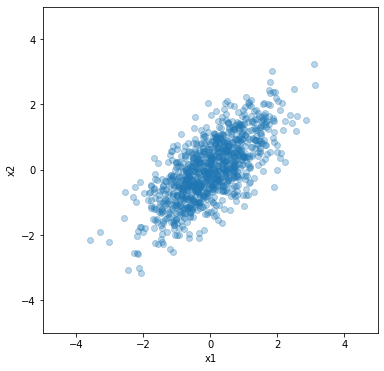

In [7]:
mu = [0.0, 0.0]
sigma1 = 1.0
sigma2 = 1.0
covariance = 0.7
cov = np.array([
    [sigma1, covariance],
    [covariance, sigma2]
])
samples = pm.draw(pm.MvNormal.dist(mu=mu, cov=cov), 1000)

x1 = samples[:, 0]
x2 = samples[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(x1, x2, alpha=0.3)
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5]);
ax.set_xlabel("x1");
ax.set_ylabel("x2");

Instead of a perfect circle, we've now got a diagonal band.  The main new thing you might see here is `cov`.  This is the covariance matrix.  The covariance matrix is a square array of numbers, so there are always an equal number of rows and columns.  There is one row and one column per dimension.  That's why `cov` in this example is two by two.  Each row and each column correspond to one of the dimensions.  

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0pky"></th>
    <th class="tg-c3ow"><span style="font-weight:bold">Dimension 1</span></th>
    <th class="tg-c3ow"><span style="font-weight:bold">Dimension 2</span></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky"><span style="font-weight:bold">Dimension 1</span></td>
    <td class="tg-c3ow">$\sigma^2_{11}$</td>
    <td class="tg-c3ow">$\sigma^2_{12}$</td>
  </tr>
  <tr>
    <td class="tg-0pky"><span style="font-weight:bold">Dimension 2</span></td>
    <td class="tg-c3ow">$\sigma^2_{12}$</td>
    <td class="tg-c3ow">$\sigma^2_{22}$</td>
  </tr>
</tbody>
</table>

If you return to the scatterplot above, you'll see we used the positive value of 0.7.  The fact that this value is positive means, when x1 is large, its more likely that x2 is also large.  Lets cover the left two thirds of the plot:

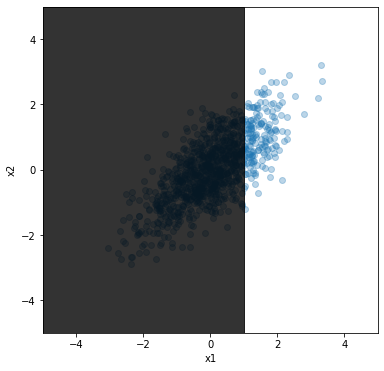

In [8]:
from matplotlib.patches import Rectangle

mu = [0.0, 0.0]
sigma1 = 1.0
sigma2 = 1.0
covariance = 0.7
cov = np.array([
    [sigma1, covariance],
    [covariance, sigma2]
])
samples = pm.draw(pm.MvNormal.dist(mu=mu, cov=cov), 1000)

x1 = samples[:, 0]
x2 = samples[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(x1, x2, alpha=0.3)
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_xlabel("x1");
ax.set_ylabel("x2");

ax.add_patch(Rectangle((-5, -5), 6, 10, alpha=0.8, color="k"));

You can see it now, when `x2` is "large", meaning here, above 1, then the points usually are larger values of `x2`.  I'm using the word "usually" on purpose.  Some amount of covariance doesn't guarantee this to be true, it just makes it more likely.  However, the larger values of covariance, the more likely this is true.  To see that this is true, let's take a look at this when the covariance is one, equal to the variance:

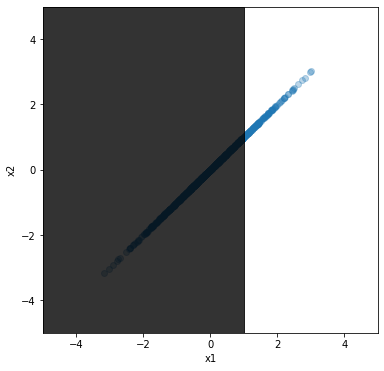

In [9]:
mu = [0.0, 0.0]
sigma1 = 1.0
sigma2 = 1.0
covariance = 1.0 # change this to one.
cov_matrix = np.array([
    [sigma1, covariance],
    [covariance, sigma2]
])
samples = pm.draw(pm.MvNormal.dist(mu=mu, cov=cov_matrix), 1000)

x1 = samples[:, 0]
x2 = samples[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(x1, x2, alpha=0.3)
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_xlabel("x1");
ax.set_ylabel("x2");

ax.add_patch(Rectangle((-5, -5), 6, 10, alpha=0.8, color="k"));

When the covariance is equal to the variance, you can see that the word "usually" turns into the word "always".  $x1 = x2$, or, if I tell you what the value of $x1$ is, you'll be able to tell me the value of $x2$ exactly. 

The best way to really understand this is to experiment.  Try choosing different values for the mean `mu`, the dimension 1 variance, the dimension 2 variance and the covariance, and then draw and plot the samples.  Here are a few important characteristics that you'll see:

- Increasing the variances stretch the distribution, but only in that particular dimension
- The variances on the diagonal must be positive
- The covariance can be negative or positive
- When you pick covariance values that are larger than the variances, you'll get a long stack trace and some message about the matrix not being positive semi-definite.  This is a mathematical condition that just means you're out of bounds with your choice of covariance.  When you get this error, decrease the value of the covariance that you just increased.

## Covariance and Correlation (TODO)
https://stats.stackexchange.com/a/413092

* Correlation is normalized version of covariance
* -1 means exact negative
* 1 means exact positive
* 0 means no relation
* While thats good to know, doesnt really matter for GPs

## Practical examples

Think about siblings and height.  Think of 100 pairs of siblings.  If a brother is taller than average, would you guess the sister is also more likely to be taller than average?  It's certainly not a guarantee, but it's probably more likely.  

Also, think about sales at a restaurant.  If there are a lot of customers during the lunch rush, from 12 noon to 1pm.  Are there likely to be a lot of customers in the next hour?  From 1 to 2pm?  The 12 to 1pm customer count is *at least* likely to be more similar to the 1 to 2pm count, than it is to the 3 to 4pm count.

## Section Recap
* Multivariate normals are an important case of randomness
* MVNs generate random vectors of size N
* MVNs are defined by $\mu$ and $\sigma$, but also covariance matrix
* Covariance, and correlation, specify degree of relation between pairwise variables or dimensions
* In real life many things are related
  * Sibling heights due genetics
  * The number of customers in two adjacent time slots in restaurants
  * Number of Intutive Bayes courses you take and your knowledge practical Bayesian usage


Hopefully the last one is positively correlated

# Sec 30: A different way to visualize multivariate normals: Seeing in N Dimensions

We can't really plot multivariate normal distributions that have more than three dimensions.  Even then, it's really not easy to see what's going on, it just looks like a formless blob of dots.  Let's try a new plot.  Instead of each dimension getting it's own axis, let's plot each dimension down the axis, as if they were sequential points in time.  Here's what I mean, in three dimensions:  

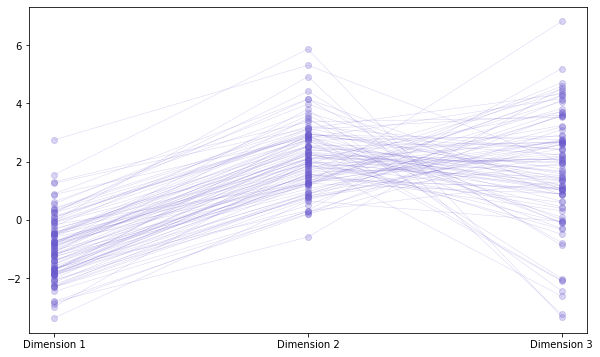

In [43]:
mu = [-1, 2, 2]

sigma1 = 1.0
sigma2 = 1.0
sigma3 = 3.0
covariance12 = 0.8
covariance13 = 0.1
covariance23 = -0.9

cov_matrix = np.array([
    [sigma1, covariance12, covariance13],
    [covariance12, sigma2, covariance23],
    [covariance13, covariance23, sigma3],
])
samples = pm.draw(pm.MvNormal.dist(mu=mu, cov=cov_matrix), 100)

dimension = np.arange(len(mu))

fig, ax = plt.subplots(1, 1, figsize=(10, 6));
ax.plot(dimension, samples.T, color="slateblue", lw=0.5, alpha=0.25, marker="o");
ax.set_xticks(dimension)
ax.set_xticklabels(["Dimension " + str(i) for i in dimension + 1]);

##### What does covariance look like in this context?

- When you go from dimension 1 to dimension 2, consider the value of `covariance12`.  It's positive, and the lines basically never cross each other. As the value in dimension one increases, so does the value in dimension 2.
- Look at dimension 2 to 3, and consider the value of `covariance23`.  It's negative, and basically every line crosses.  If it's relatively high in dimension 2, it goes down and is low in dimension 3, and visa versa. 
- What about `covariance13`?  It's here, but it's invisible in this plot.  It's doing something similar to `covariance12` and `covariance13`.  But, that's the thing about projecting a higher dimensional thing down into a lower dimensional space.  Things in higher dimensions do have real effects, but these effects are invisible from lower dimensional viewpoints.  The effects they produce are real, but the mechanism isn't apparent. 

Again, I encourage you to play with the numbers here and see what happens.  Nothing is stopping us from making this type of plots in even higher dimensions, even hundreds or thousands of dimensions is possible.  We'll make plots of Gaussian proceses that look like this many many times in this course!

# Sec 40: More than three dimensions

To solidify our understanding, let's repeat the same thing as above but instead let's go from 3 to 10 dimensions.  We'll use a few simple rules to produce the covariance matrix for this demonstration.  We'll repeat this a couple times using different rules to get a feel for what these values do to the covariance matrix and the sample functions it produces. We'll start simple though, the first rules are

- points one step away have a covariance of 0.7
- everything else is zero, except for the diagonal, which is all ones

The code for this is below, along with an image of the matrix (we'll look at "images" of covariance matrices again in the future). 

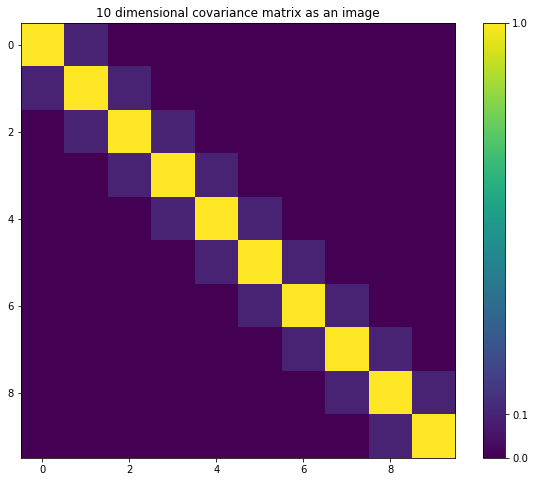

In [84]:
cov_matrix = np.zeros((10, 10))

for i in range(10):
    for j in range(10):
        
        if i == j:
            cov_matrix[i, j] = 1.0
        
        elif np.abs(i - j) == 1:
            cov_matrix[i, j] = 0.1
        
            
fig, ax = plt.subplots(1,1,figsize=(10, 8))

m = ax.imshow(cov_matrix)
cbar = fig.colorbar(m, ax=ax, ticks=[0, 0.1, 1.0])
ax.set_title("10 dimensional covariance matrix as an image");

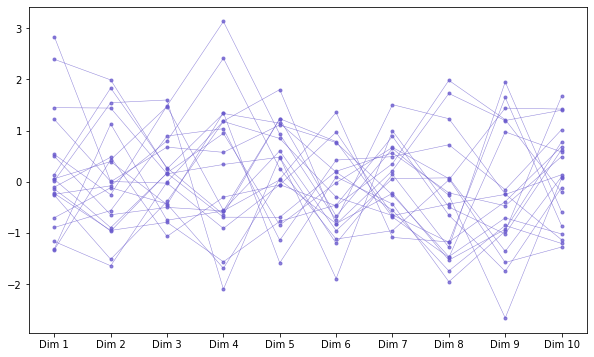

In [85]:
# Lets use a zero mean this time
mu = np.zeros(10)
    
# Draw samples from this random vector
random_vector = pm.MvNormal.dist(mu=mu, cov=cov_matrix)
samples = pm.draw(random_vector, draws=100)

x = np.arange(len(mu))
fig, ax = plt.subplots(1,1,figsize=(10, 6))

# plot 100 of the samples
ix = np.random.randint(0, samples.shape[0], 20)
ax.plot(x, samples[ix, :].T, color="slateblue", lw=0.5, alpha=0.75, marker=".")

ax.set_xticks(x);
ax.set_xticklabels(["Dim " + str(i + 1) for i in range(len(x))]);

Pretty noisy.  The covariance matrix is nearly the identity matrix, which is independent white noise.  Let's increase the 1-step covariances.  The new rules are:

- points one step away have a covariance of 0.5
- everything else is zero, except for the diagonal, which is all ones

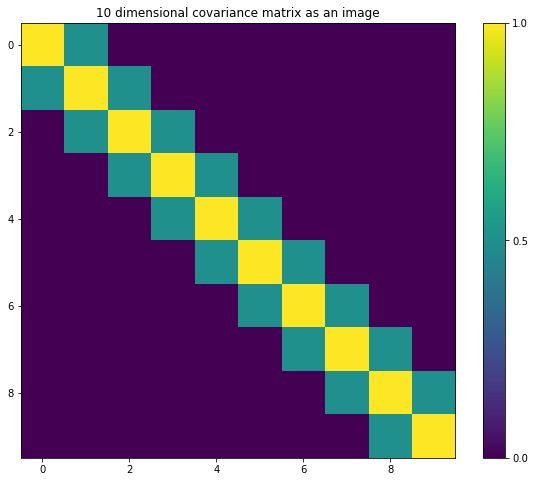

In [86]:
cov_matrix = np.zeros((10, 10))

for i in range(10):
    for j in range(10):
        
        if i == j:
            cov_matrix[i, j] = 1.0
        
        elif np.abs(i - j) == 1:
            cov_matrix[i, j] = 0.5
        
            
fig, ax = plt.subplots(1,1,figsize=(10, 8))

m = ax.imshow(cov_matrix)
cbar = fig.colorbar(m, ax=ax, ticks=[0, 0.5, 1.0])
ax.set_title("10 dimensional covariance matrix as an image");

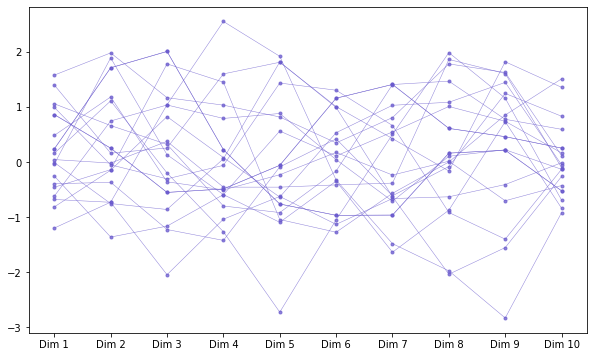

In [87]:
# Lets use a zero mean this time
mu = np.zeros(10)
    
# Draw samples from this random vector
random_vector = pm.MvNormal.dist(mu=mu, cov=cov_matrix)
samples = pm.draw(random_vector, draws=100)

x = np.arange(len(mu))
fig, ax = plt.subplots(1,1,figsize=(10, 6))

# plot 100 of the samples
ix = np.random.randint(0, samples.shape[0], 20)
ax.plot(x, samples[ix, :].T, color="slateblue", lw=0.5, alpha=0.75, marker=".")

ax.set_xticks(x);
ax.set_xticklabels(["Dim " + str(i + 1) for i in range(len(x))]);

Things look a little less "noisy" here.  We can start to visually see that the covariance between nearby points is working to sort of smooth out these lines.  Let's add a few more rules to keep going in this direction:


- points one step away have a covariance of 0.7
- points two steps away have a covariance of 0.5
- points three steps away have a covariance of 0.3
- points four steps away have a covariance of 0.1
- everything else is zero, except for the diagonal, which is all ones

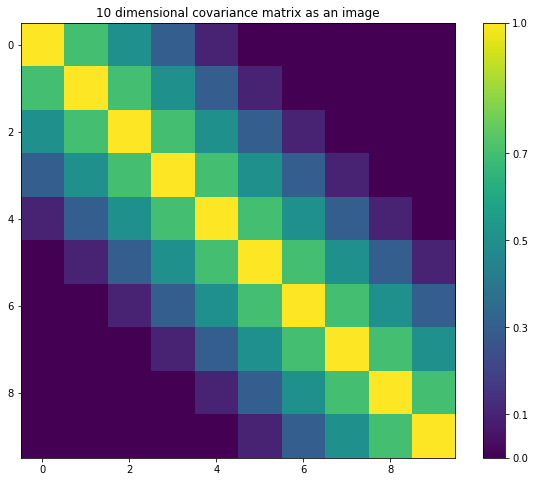

In [92]:
cov_matrix = np.zeros((10, 10))

for i in range(10):
    for j in range(10):
        
        if i == j:
            cov_matrix[i, j] = 1.0
        
        elif np.abs(i - j) == 1:
            cov_matrix[i, j] = 0.7
        
        elif np.abs(i - j) == 2:
            cov_matrix[i, j] = 0.5
            
        elif np.abs(i - j) == 3:
            cov_matrix[i, j] = 0.3
            
        elif np.abs(i - j) == 4:
            cov_matrix[i, j] = 0.1
            
fig, ax = plt.subplots(1,1,figsize=(10, 8))

m = ax.imshow(cov_matrix)
cbar = fig.colorbar(m, ax=ax, ticks=[0, 0.1, 0.3, 0.5, 0.7, 1.0])
ax.set_title("10 dimensional covariance matrix as an image");

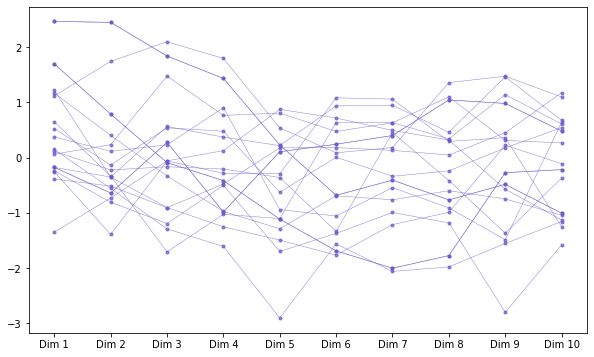

In [93]:
# Lets use a zero mean this time
mu = np.zeros(10)
    
# Draw samples from this random vector
random_vector = pm.MvNormal.dist(mu=mu, cov=cov_matrix)
samples = pm.draw(random_vector, draws=100)

x = np.arange(len(mu))
fig, ax = plt.subplots(1,1,figsize=(10, 6))

# plot 100 of the samples
ix = np.random.randint(0, samples.shape[0], 20)
ax.plot(x, samples[ix, :].T, color="slateblue", lw=0.5, alpha=0.75, marker=".")

ax.set_xticks(x);
ax.set_xticklabels(["Dim " + str(i + 1) for i in range(len(x))]);

Feel free to experiment with different values here, but watch out, for some covariance values you try  you'll probably get errors saying: `ValueError: the input matrix must be positive semidefinite`.  

Not every matrix can be a covariance matrix, and positive semidefiniteness is the name of the [mathematical condition](https://en.wikipedia.org/wiki/Definite_matrix) for checking this.  For working with GPs, it's not necessary to use this condition to validate covariance matrices, there are other rules that are easier to work with that we can lean on, and we'll see those later.  However, you will undoubtedly see this error from time to time.  It *usually* means that the diagonal of your matrix isn't quite large enough.  You can often make it go away by adding a bit to the diagonal, so the first thing to try is `cov_matrix + 1e-6 * np.eye(n)`.  

## Multivariate normal wrap-up

The amount of knowledge out there on normal and multivariate normals is pretty vast.  A quick skim of the wikipedia page will tell you as much.  We have enough understanding of multivariate normals to turn back towards Gaussian processes.   

We will return to multivariate normals in a later lesson after we fit our first GPs.  Two other multivarate normal concepts are important for working with and speeding up GPs, **marginalization** and **conditioning**.  

## Section Recap
* Multivariate Normals can, and often do, extend past 3 dimensions
* To visualize higher dimensions we can plot them in what's called a parallel plot
  * Each dimension is on the x axis
  * The y is the value of the random draws
  * A continuous line connects the vector of points together
  * These lines are not strictly parallel, making the plot name a bit unfortunate